In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import constants as cst
from astropy import units as u

# purely for plotting result and generating pixels on a sphere
import healpy as hp

# I just copied the functions from the files below into this notebook, so you only need the notebook.
# from aqn import *
# from constants import *
# from survey_parameters import *
# from aqn_simulation import *

In [2]:
# ----------------------------- unit conversions ----------------------------- 
eV_to_erg = 1e7*cst.e.si.value*u.erg/u.eV
GeV_to_erg = eV_to_erg.to(u.erg/u.GeV)
erg_to_eV = 1/eV_to_erg
erg_to_MeV = erg_to_eV.to(u.MeV/u.erg)
erg_to_GeV = erg_to_eV.to(u.GeV/u.erg)

cm_to_inverg = 1/(cst.hbar.cgs*cst.c.cgs)
inverg_to_cm = 1/cm_to_inverg
m_to_inverg = 1/(cst.hbar.cgs*cst.c.cgs) * 100 * u.cm / u.m                                                                                                             #              !!!
invm3_to_GeV3 = 1 / m_to_inverg**3 * erg_to_GeV**3                                                                                                                      #              !!!

kpc_to_cm = (u.kpc).to(u.cm) * u.cm / u.kpc

K_to_eV = cst.k_B.cgs*erg_to_eV
eV_to_K = 1/K_to_eV
Hz_to_eV = cst.hbar.cgs*erg_to_eV
Hz_to_erg = cst.hbar.cgs * 1/u.s * 1/u.Hz #                                                                                is this correct?
cm_to_GeVinv = 1e7*cst.e.si.value*1e9/(cst.hbar.cgs.value*cst.c.cgs.value)/u.GeV/u.cm
cm_to_eVinv = 1e7*cst.e.si.value/(cst.hbar.cgs.value*cst.c.cgs.value)/u.eV/u.cm
GeVinv_to_cm = 1/cm_to_GeVinv
eVinv_to_cm = 1/cm_to_eVinv
1/u.GeV*GeVinv_to_cm
g_to_GeV = cst.c.cgs.value**2/(1e7*cst.e.si.value*1e9)*u.GeV/u.g
GeV_to_g = 1/g_to_GeV

invcm_to_erg = 1/cm_to_GeVinv * GeV_to_erg

# ----------------------------- functions -----------------------------
def sech(x):
    return 1 / np.cosh(x)

nuclear_density_cgs = (3.5e17 * u.kg/u.m**3).cgs

def calc_m_AQN(R):
    return 4/3 * np.pi * R.cgs**3 * nuclear_density_cgs
def calc_R_AQN(m):
    return (3/4 * m.cgs/nuclear_density_cgs * 1/np.pi)**(1/3)

# ----------------------------- constants ----------------------------- 

m_e_eV  = (cst.m_e.cgs*cst.c.cgs**2).value * u.erg * erg_to_eV  # mass of electron    in eV
m_e_erg = (cst.m_e.cgs*cst.c.cgs**2).value * u.erg              # mass of electron    in erg
m_p_erg = (cst.m_p.cgs).to(u.erg, u.mass_energy())              # mass of proton      in erg

B = 10**25                                                  # Baryon charge number
E_ann_GeV = 2 * u.GeV                                       # energy liberated by proton annihilation
f  = 1/10                                                   # factor to account for probability of reflection
g  = 1/10                                                   # (1-g) of total annihilation energy is thermalized     
Dv = 0.00013835783 * u.dimensionless_unscaled               # speed of nugget through visible matter
Dv = 10**-3 * u.dimensionless_unscaled

# Define AQN parameters

In [3]:
# define AQN parameters
m_aqn_kg = 0.01*u.kg
R_aqn_cm = calc_R_AQN(m_aqn_kg)

print("using m_aqn =", m_aqn_kg)
print("using R_aqn =", R_aqn_cm)

using m_aqn = 0.01 kg
using R_aqn = 1.8964778823564563e-05 cm


# Define survey parameters

In [4]:
# specify frequency resolution and create frequency band array
# Change frequency range within survey_parameters.py
################ WMAP K-Band ###################################
# Source: https://lambda.gsfc.nasa.gov/product/wmap/current/
f_centre_GHz = 23 * u.GHz
f_min_hz = (f_centre_GHz - 5.5/2 * u.GHz).to(u.Hz)
f_max_hz = (f_centre_GHz + 5.5/2 * u.GHz).to(u.Hz)
skymap_units = u.Jy

# from erg/s/Hz/cm2 to mK
def convert_to_skymap_units(F_erg_hz_cm2,nu):
    erg_hz_cm2 = 1*u.erg/u.s/u.Hz/u.cm**2
    C = erg_hz_cm2.to(skymap_units)
    return (F_erg_hz_cm2 * C / erg_hz_cm2).to(u.mK, equivalencies = u.brightness_temperature(nu))


frequency_band_resolution = 1e8
frequency_band = np.arange(f_min_hz.value, f_max_hz.value, frequency_band_resolution) * u.Hz

print("A heavy computation will need to be run " + str(len(frequency_band)) + 
      " times, which can be accelerated by parallel computing")

A heavy computation will need to be run 55 times, which can be accelerated by parallel computing


# Define simulation resolution

In [5]:
sun_mw_distance_kpc = 8*u.kpc
NSIDE = 2**5
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)

# Prepare arrays for integration

In [6]:
# array of theta, phi, for each pixel
theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))
dl =  0.01 * u.kpc
l_min, l_max = 0, 0.6 # np.max(distances) = 17.2867 kpc
l_list = np.arange(l_min,l_max,dl.value)[:, np.newaxis]
# 2D array of distance elements along each sightline
l = np.ones((len(l_list),len(theta))) * l_list

# (l,theta,phi) -> (x,y,z)
x = l * np.sin(theta) * np.cos(phi) - sun_mw_distance_kpc.value
y = l * np.sin(theta) * np.sin(phi)
z = l * np.cos(theta)

R = np.sqrt(x**2 + y**2 + z**2)

# Compute using data cubes

In [7]:
# import cubes and grid_coords -- need to get these from me separately
grid_coords = np.load("../data/FIRE/grid-coords.npy")
grid_ids = np.load("../data/FIRE/grid-ids---dark_mat.npy")

cubes = {}
cubes["dark_mat"] = np.load("../data/FIRE/cubes/cube-dark_mat_density.npy") * u.kg/u.m**3
cubes["ioni_gas"] = np.load("../data/FIRE/cubes/cube-ioni_gas_density.npy") * u.kg/u.m**3
cubes["neut_gas"] = np.load("../data/FIRE/cubes/cube-neut_gas_density.npy") * u.kg/u.m**3
cubes["temp_ion"] = np.load("../data/FIRE/cubes/cube-ioni_gas_temp.npy") * u.K
cubes["dv_ioni"]  = np.load("../data/FIRE/cubes/cube-dv_ioni.npy") * u.m/u.s
cubes["dv_neut"]  = np.load("../data/FIRE/cubes/cube-dv_neut.npy") * u.m/u.s

# # compute distance from every grid centre to galactic centre
distances = np.sqrt(np.sum(grid_coords**2, axis=1)) * u.kpc

In [8]:
# perform some unit conversions
cubes["ioni_gas"] = (cubes["ioni_gas"]/cst.m_p.si).to(1/u.cm**3)
cubes["neut_gas"] = (cubes["neut_gas"]/cst.m_p.si).to(1/u.cm**3)
cubes["dark_mat"] = (cubes["dark_mat"]/  m_aqn_kg).to(1/u.cm**3)
cubes["temp_ion"] =  cubes["temp_ion"]*K_to_eV
cubes["dv_ioni"]  =  cubes["dv_ioni"] /cst.c
cubes["dv_neut"]  =  cubes["dv_neut"] /cst.c

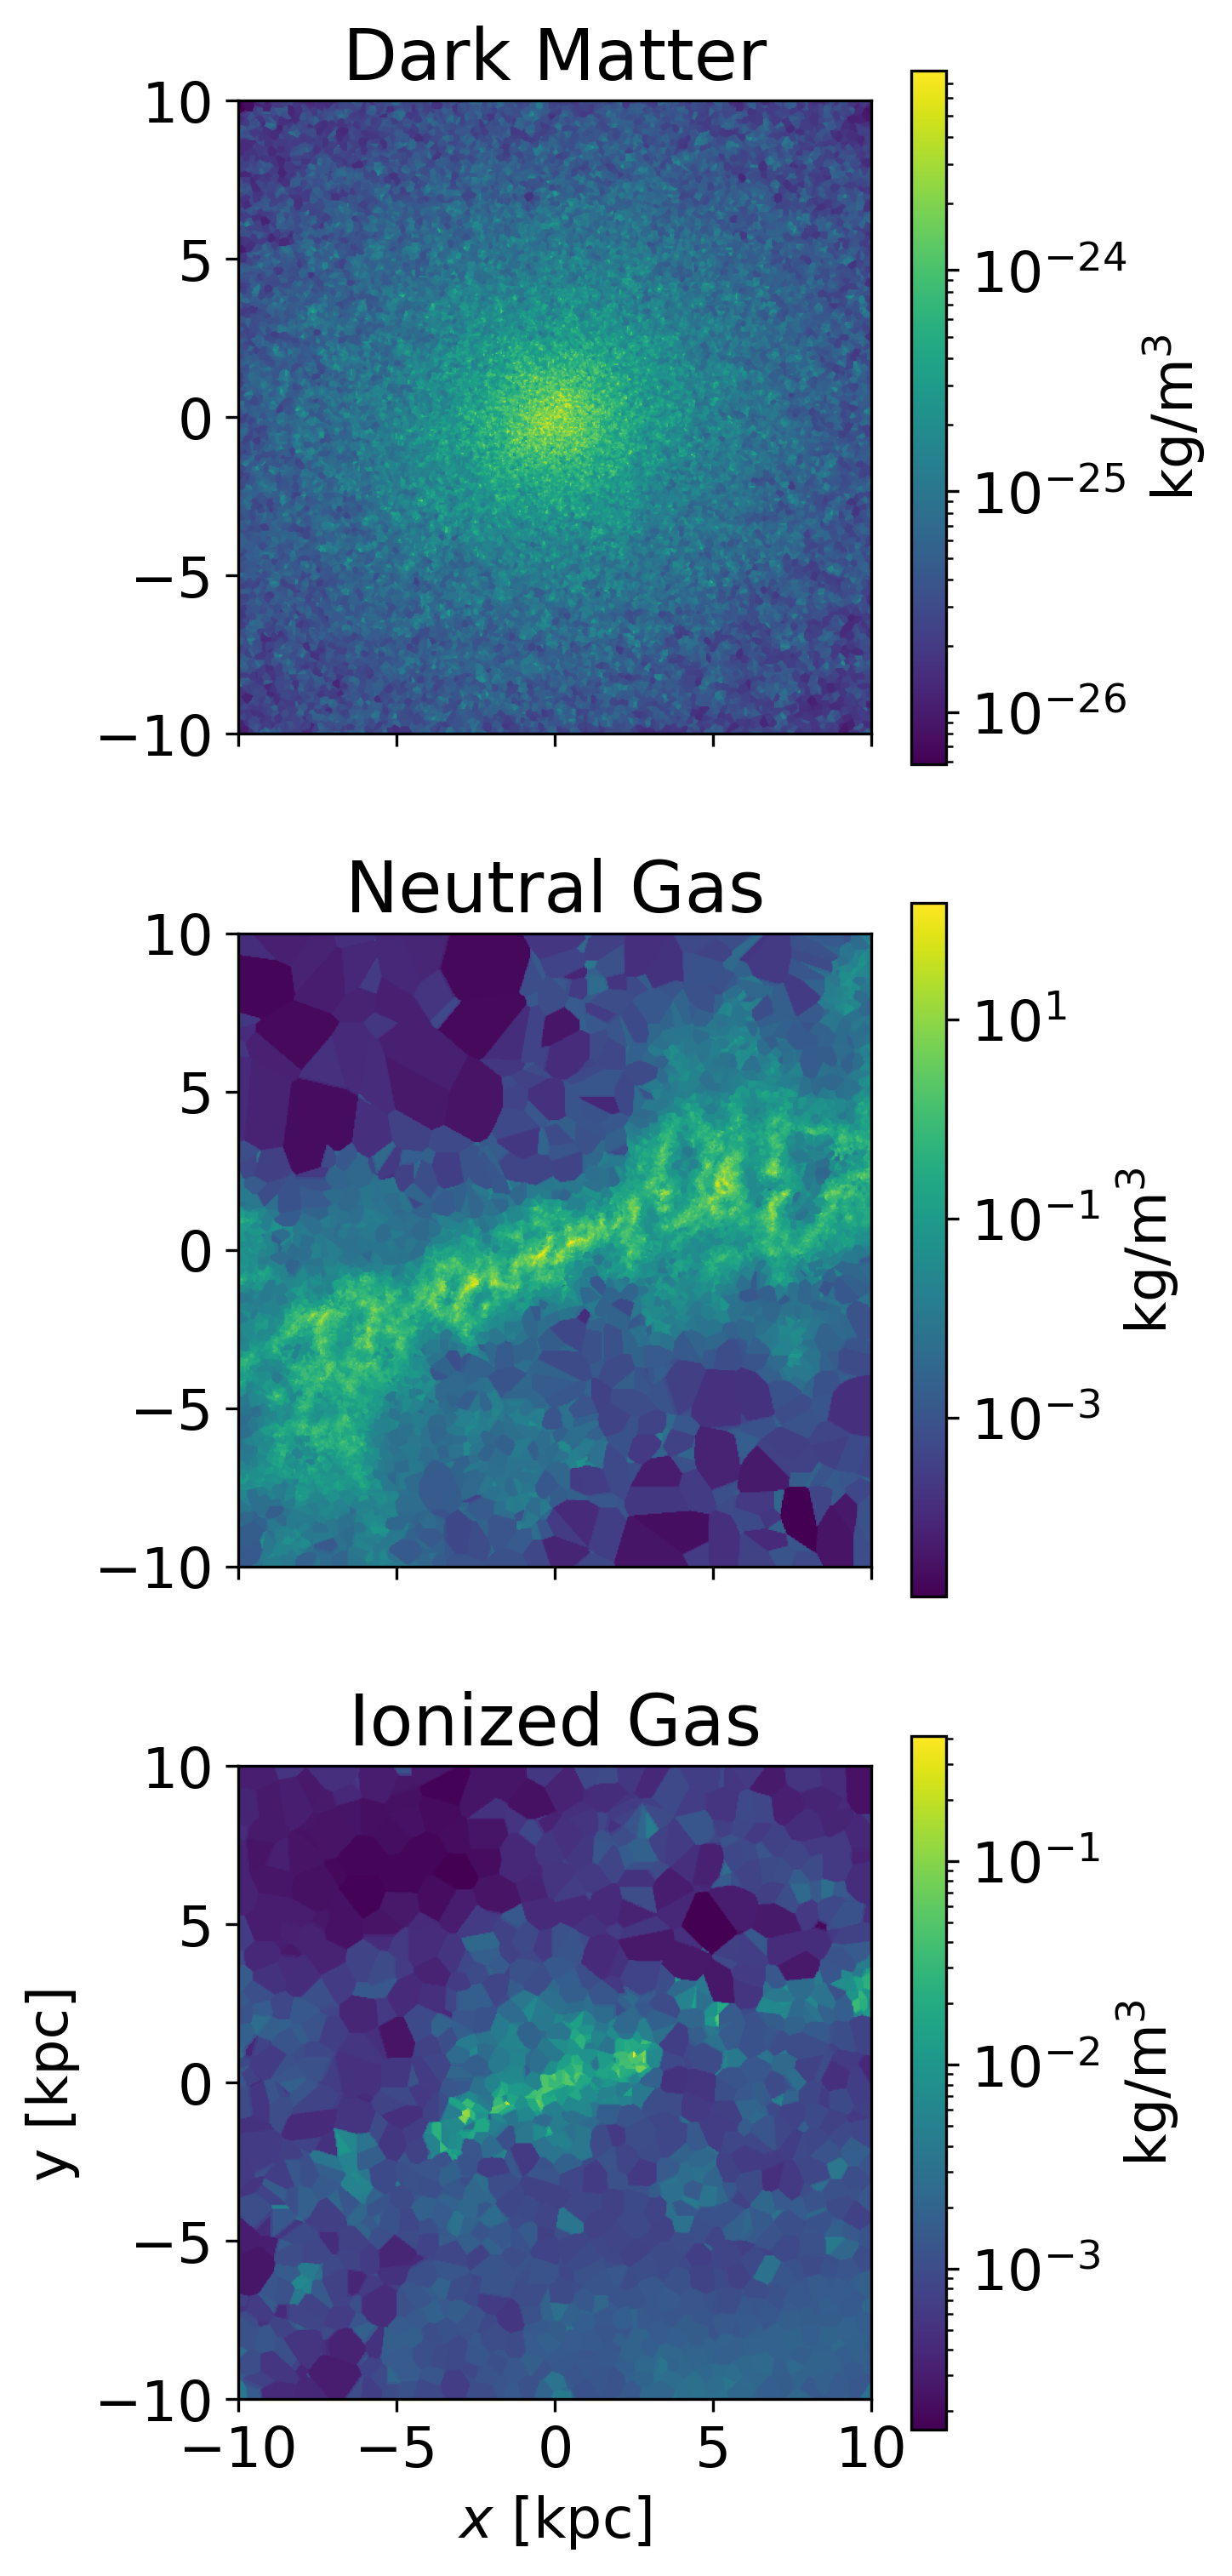

In [9]:
fig, axs = plt.subplots(3, 1, dpi=300, sharex = True, sharey = True, figsize=(4,12))

names = ["Dark Matter", "Neutral Gas", "Ionized Gas"]
for i, dictt in enumerate(["dark_mat", "neut_gas", "ioni_gas"]):
    xx = cubes[dictt]
    resolution = np.shape(xx)[0]
    voxel_centers = np.reshape(grid_coords, (resolution, resolution, resolution, 3))[0][:,0,0]
    voxel_centers = np.array([voxel_centers, voxel_centers, voxel_centers])
    z_slice_min, z_slice_max = [-0.05,0.05]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
    slice_count = np.average(xx[:,:,mask], axis=2).value

    c = axs[i].imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())

    axs[i].set_xticks(np.array([-10,-5,0,5,10]))
    axs[i].set_yticks(np.array([-10,-5,0,5,10]))
    axs[i].tick_params(axis='both', labelsize=16)
    axs[i].set_title(names[i], size=20)

    cbar = fig.colorbar(c, ax=axs[i])
    cbar.set_label(r'kg/m$^3$', size=16)
    cbar.ax.tick_params(labelsize=16)

axs[2].set_ylabel("y [kpc]",size=16)
axs[2].set_xlabel('$x$ [kpc]', size=16)

plt.savefig("column-plot"+".pdf", bbox_inches='tight')
plt.show()

# Calculate spectral spatial emissivity

In [10]:
def T_AQN_analytical(n_bar, Dv, f, g):
    return ((1-g) * np.pi * 3/16 * 1/(cst.alpha**(5/2)) * (m_e_erg)**(1/4) * 
            (E_ann_GeV * GeV_to_erg) * f * Dv * ((n_bar).to(1/u.cm**3) * invcm_to_erg**3))**(4/17) * erg_to_eV

def T_AQN_ionized2(n_bar, Dv, f, g, T_p, R):
    n_bar_erg = n_bar.to(1/u.cm**3) * 1/cm_to_inverg**3
    return (3/4 * np.pi * (1-g) * f * Dv * 1/cst.alpha**(3/2) * m_p_erg * n_bar_erg * 
            R**2 * cm_to_inverg**2 * 
            1/T_p**2 * 1/eV_to_erg**2)**(4/7)* (m_e_erg) * erg_to_eV

In [11]:
# compute T_AQN
cubes["t_aqn_n"] = T_AQN_analytical(cubes["neut_gas"], cubes["dv_neut"], f, g)
cubes["t_aqn_i"] = T_AQN_ionized2(cubes["ioni_gas"], cubes["dv_ioni"], f, g, cubes["temp_ion"], R_aqn_cm)
# if ioni temp is lower than neut temp, replace with neut temp
cubes["t_aqn_i"][cubes["t_aqn_i"]<cubes["t_aqn_n"]] = cubes["t_aqn_n"][cubes["t_aqn_i"]<cubes["t_aqn_n"]]

# Parallelizable Function

In [12]:
m_e_eV  = (cst.m_e.cgs*cst.c.cgs**2).value * u.erg * erg_to_eV  # mass of electron    in eV

# from erg/s/Hz/cm2 to mK
skymap_units = u.Jy
def convert_to_skymap_units(F_erg_hz_cm2,nu):
    erg_hz_cm2 = 1*u.erg/u.s/u.Hz/u.cm**2
    C = erg_hz_cm2.to(skymap_units)
    return (F_erg_hz_cm2 * C / erg_hz_cm2).to(u.mK, equivalencies = u.brightness_temperature(nu))

# h function with array operations
h_func_cutoff = 17 + 12*np.log(2)
def h(x):
    return_array = np.copy(x)
    return_array[np.where(x<1)] = (17 - 12*np.log(x[np.where(x<1)]/2))
    return_array[np.where(x>=1)] = h_func_cutoff
    return return_array

def spectral_surface_emissivity(nu, T):
    T = T * eV_to_erg
    w = 2 * np.pi * nu * Hz_to_erg
    unit_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
    #                ^ 1/seconds           ^ 1/area                          ^ 1/frequency and energy
    return unit_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w/T) * np.exp(- w/T) * h(w/T)

# Parallelizable Loop

In [13]:
cubes["aqn_emit"] = np.zeros(np.shape(cubes["t_aqn_n"])) *  u.mK # (u.erg/(u.Hz*u.s*u.cm**2)) # photons/s/A/cm2

# this is the loop that can be run in parallel.
for nu in frequency_band:
    cubes["aqn_emit"] += convert_to_skymap_units(spectral_surface_emissivity(nu, cubes["t_aqn_n"])/(dOmega*u.sr), nu) + \
                         convert_to_skymap_units(spectral_surface_emissivity(nu, cubes["t_aqn_i"])/(dOmega*u.sr), nu)

cubes["aqn_emit"] = cubes["aqn_emit"] * 4 * np.pi * R_aqn_cm**2 * cubes["dark_mat"]

# Integrate using data cubes

## The nearest neighbour search in this section could be parallelized too

In [14]:
from scipy.spatial import cKDTree
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html
print(f">> Especially this cell, which generates a cKDTree, and the one below it (nearest neighbour queries)")
tree_points = cKDTree(grid_coords)

>> Especially this cell, which generates a cKDTree, and the one below it (nearest neighbour queries)


In [15]:
cube_indexes = np.zeros(np.shape(x))
# for each radius element
for i in range(np.shape(x)[0]):
    # find the nearest cube for all angles
    cube_indexes[i,:] = tree_points.query(np.array([x[i,:],y[i,:],z[i,:]]).T)[1]
    print((i+1)/np.shape(x)[0] * 100, end="\r")

cube_indexes = np.array(np.round(cube_indexes), dtype = np.int32)

In [16]:
cube_dimension = np.shape(cubes["aqn_emit"])[0]
flat_aqn_emit  = np.reshape(cubes["aqn_emit"],(cube_dimension**3))
f_aqn = np.sum(flat_aqn_emit[cube_indexes], axis=0) / (4*np.pi) * (dl.cgs) * dOmega

# Plot skymap of results

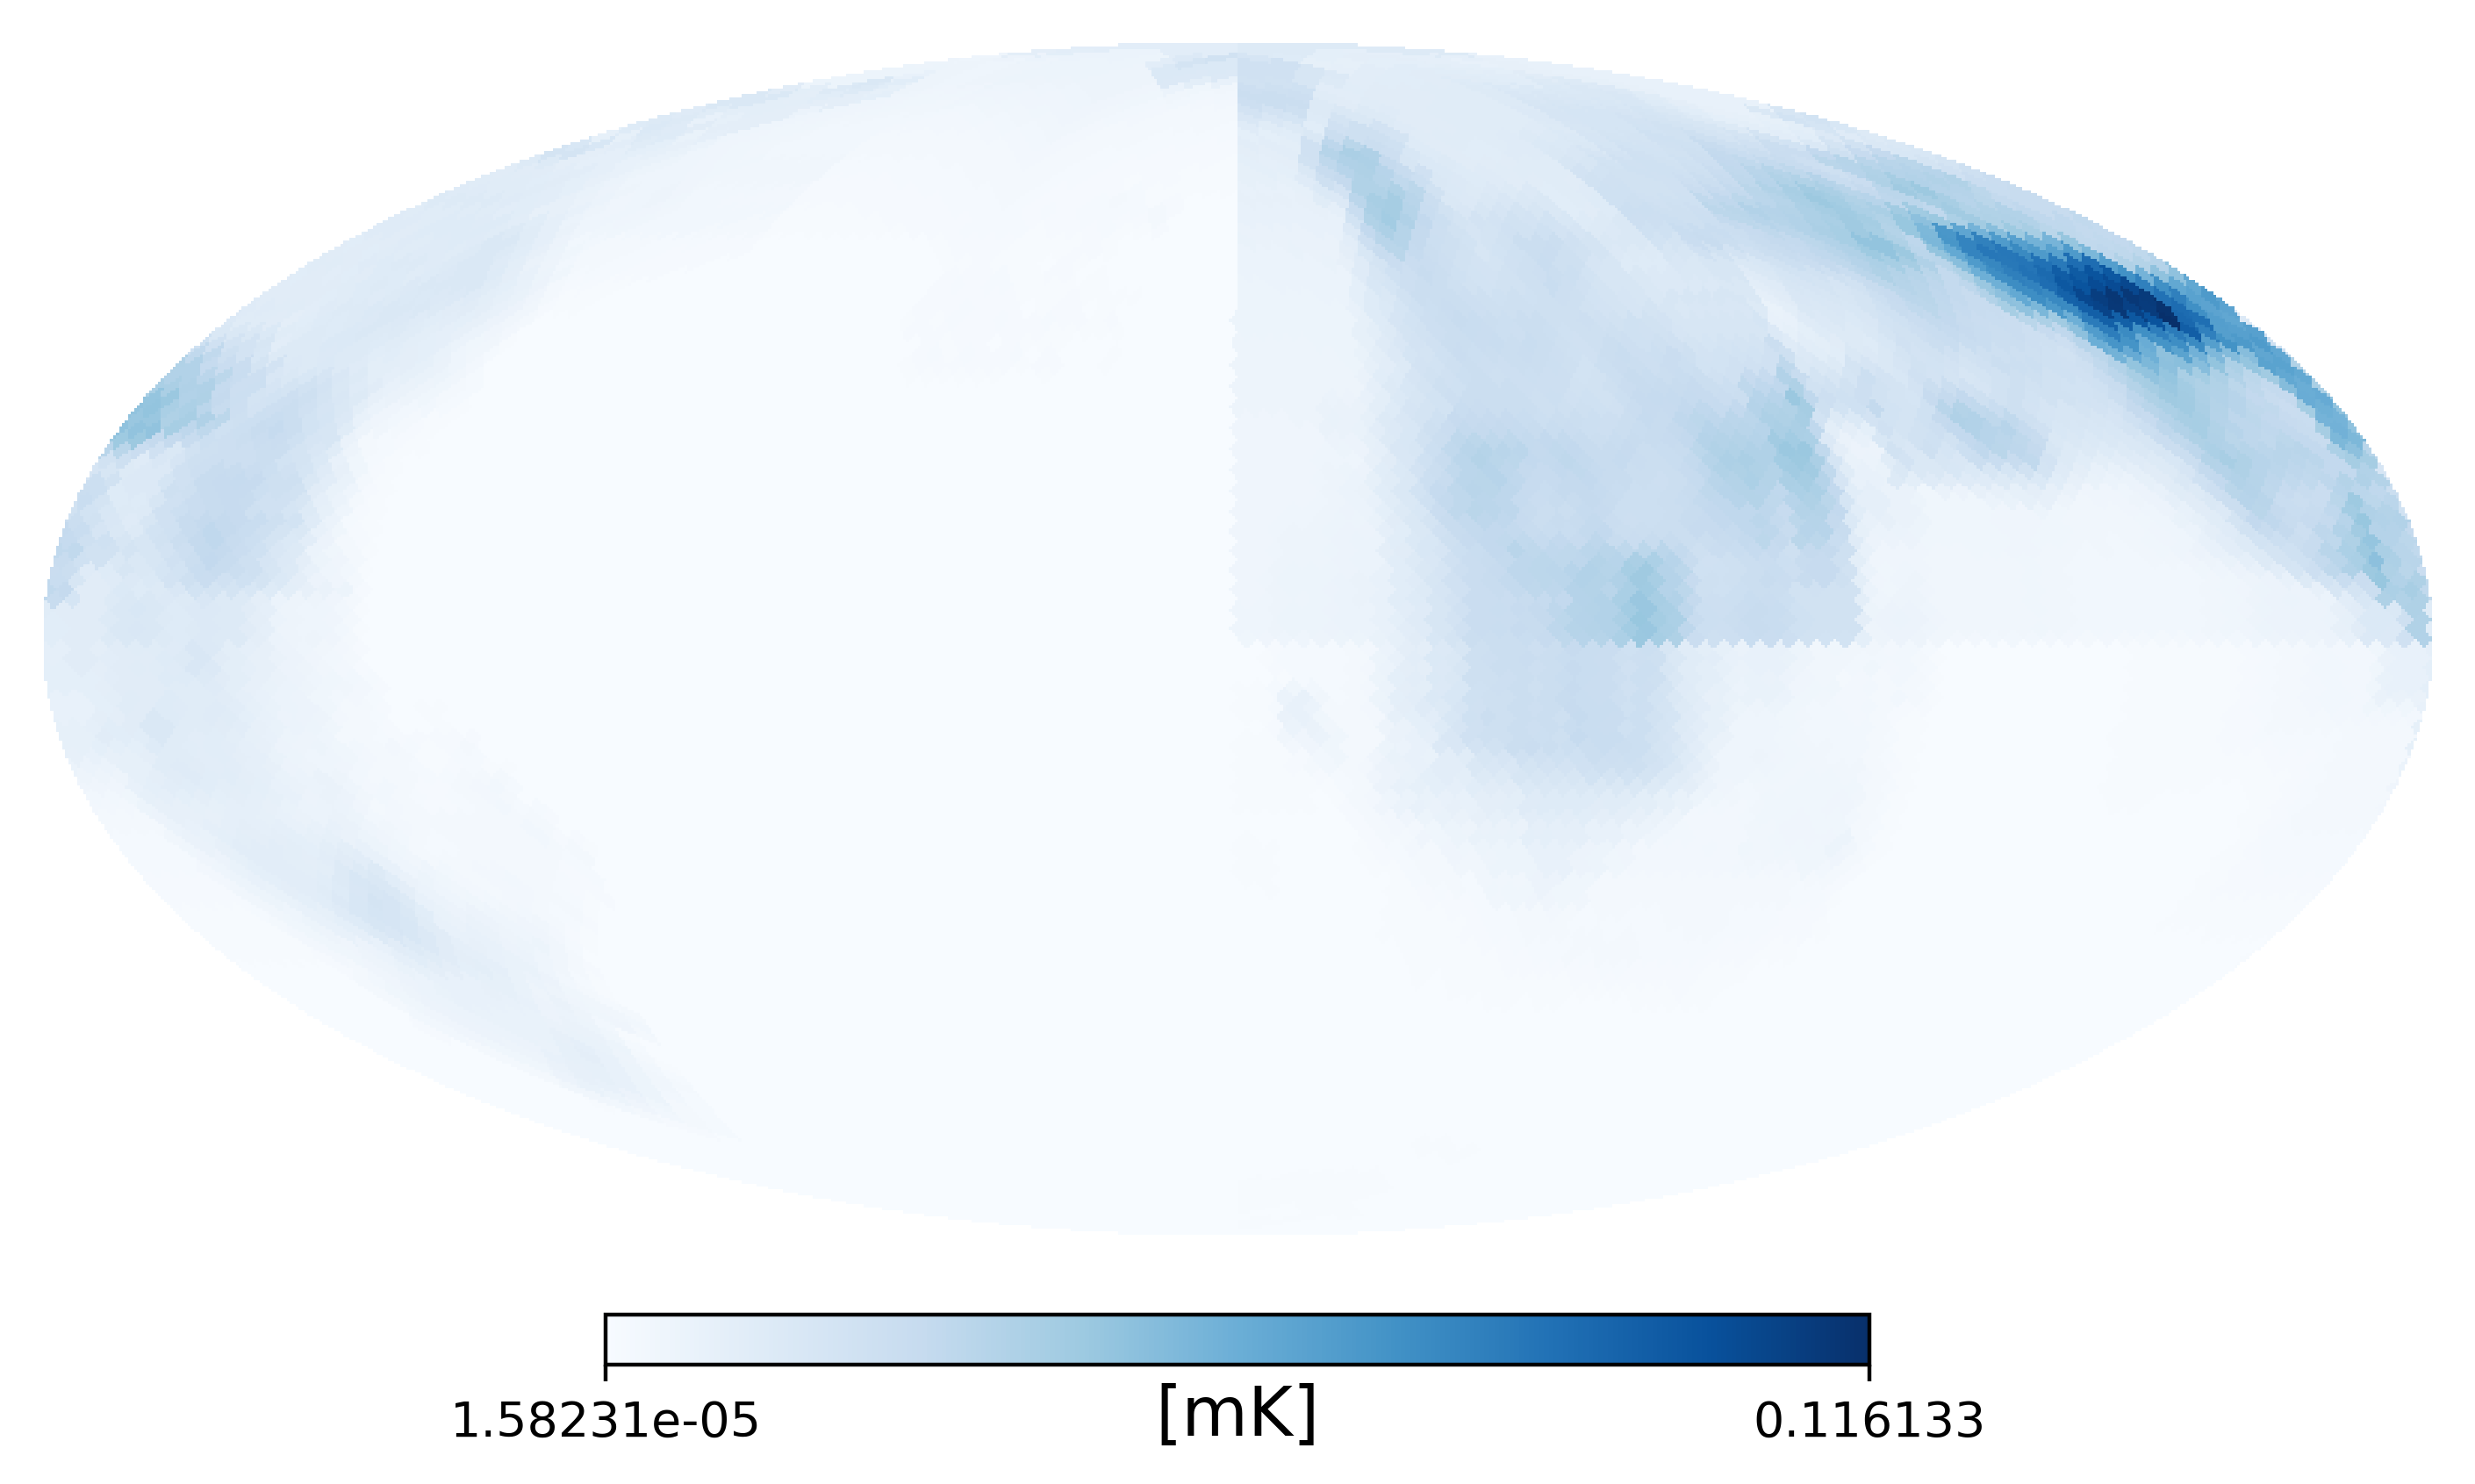

In [17]:
f1 = plt.figure(figsize=(7.5,4.5), dpi=400)
#wmaphaze[np.where(wmaphaze==0)] = -1000
# plot_wmaphaze = wmaphaze.copy()
# plot_wmaphaze[np.where(wmaphaze==0)] = np.nan
hp.mollview(f_aqn, 
            title="", 
            rot=(0,0,0),
            cmap='Blues', 
            fig=f1, 
            unit="[mK]", min = np.min(f_aqn).value, max = np.max(f_aqn).value
            #min=-0.02,
            #max=270
           )
# plt.savefig("plots/MCMC-results/25k-april1/WMAP Haze Skymap.svg")
fontsize = 24
matplotlib.rcParams.update({'font.size':fontsize})

# save_name = "wmap-skymap-simulated"
# plt.savefig(save_name+".png", bbox_inches='tight')
# plt.savefig("../visuals/numerical-skymap"+".svg", bbox_inches='tight')
plt.show()

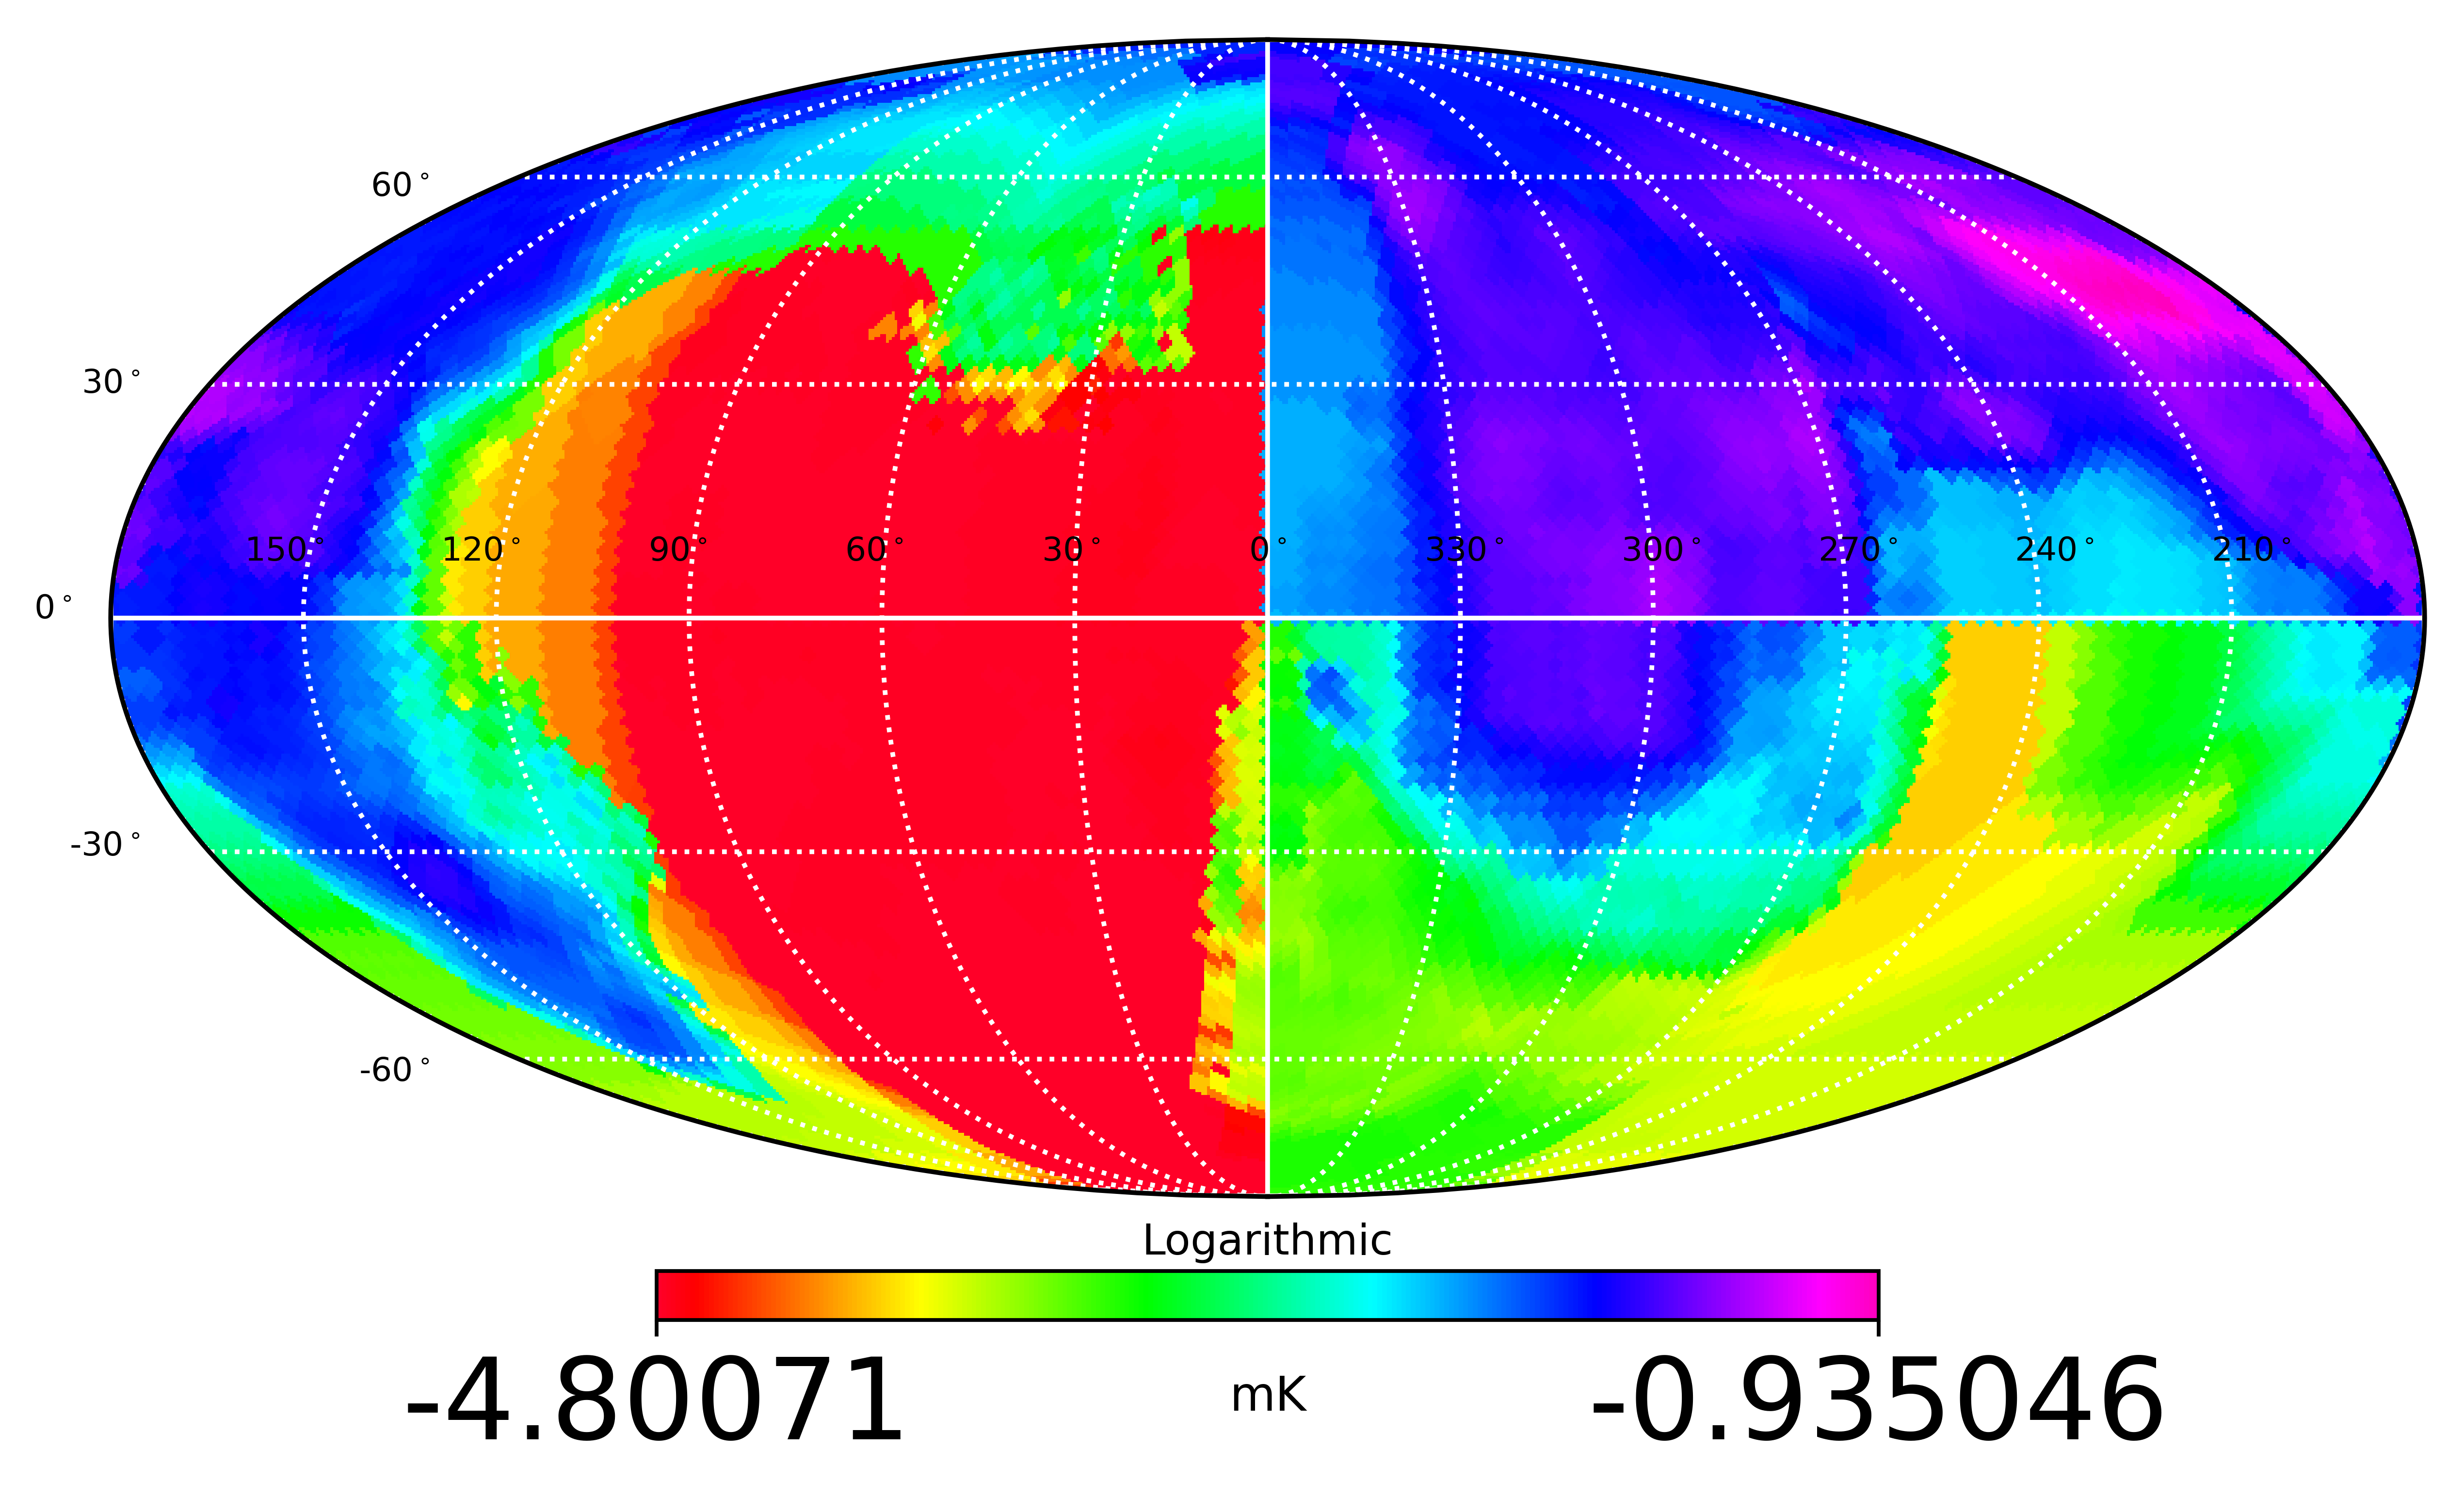

In [18]:
def create_skymap2(signal, signal_unit, log_signal):
    f1 = plt.figure(figsize=(7.5,4.5), dpi=700)
    # rotation in (lat, long, psi)
    if log_signal:
        hp.mollview(np.log10(signal.value), 
                    title="", 
                    rot=(0,0,0),
                    cmap='gist_rainbow', 
                    fig=f1, 
                    unit="")
    else:
        hp.mollview(signal.value, 
                    title="", 
                    rot=(0,0,0),
                    cmap='gist_rainbow', 
                    fig=f1, 
                    unit="")    
    #hp.graticule(dmer=360,dpar=360,alpha=0)  
    hp.graticule(dmer=30,dpar=30, alpha=1, color="white", linewidth=10)
    longitude_labels = [150,120,90,60,30,0,330,300,270,240,210]
    for i in range(len(longitude_labels)):
        plt.text((-5+i)*0.34,0.1,str(longitude_labels[i])+"$^\circ$",size=7,horizontalalignment="center")

    latitude_labels = [-60,-30,0,30,60]
    plt.text(-2.01,-0.41,"-30$^\circ$",size=7,horizontalalignment="center") 
    plt.text(-2.1,0,"0$^\circ$",size=7,horizontalalignment="center")
    plt.text(-2,0.39,"30$^\circ$",size=7,horizontalalignment="center") 
    plt.text(-1.5,0.73,"60$^\circ$",size=7,horizontalalignment="center") 
    plt.text(-1.51,-0.8,"-60$^\circ$",size=7,horizontalalignment="center") 
    if log_signal:
        plt.text(0,-1.10,"Logarithmic",size=9,horizontalalignment="center")
    #plt.text(0,-1.37,"photons$\,\cdot\,$cm$^{-2}\cdot$A$^{-1}\cdot$s$^{-1}\cdot$sr$^{-1}$",size=10,horizontalalignment="center")
    plt.text(0,-1.37,signal_unit,size=10,horizontalalignment="center")
    # plt.savefig("simulated_signal_sky_map.png")
    plt.show()

create_skymap2(f_aqn, f_aqn.unit, True)